In [10]:
# Imports
!pip install iexfinance
from iexfinance.stocks import Stock
import requests
import urllib.parse
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import time

You should consider upgrading via the '/Users/admin/.pyenv/versions/3.8.12/envs/lewagon_current/bin/python3.8 -m pip install --upgrade pip' command.


In [21]:
# params
import os
period = 'quarter'
time = '24'
symbol = ["DASH","ABNB", "TDOC", "FSLY", "COIN", "CRSP", "SE", "Z", "U"]
token = os.environ['TOKEN']
portfolio = {}
portfolio_det = {}

In [22]:
# get df from api
def get_df(ls, period, time, token):
    for ticker in ls:
        financials_url = f"https://sandbox.iexapis.com/stable/stock/{ticker}/financials?period={period}&last={time}&token={token}"
        financials_json = requests.get(financials_url).json()
        if len(financials_json) < 2:
            print(f"{ticker} has no data")
        else:
            portfolio[ticker] = pd.DataFrame(financials_json['financials'])

In [23]:
# company details
def add_company(ls):
    for ticker in ls:
        company_url = f"https://sandbox.iexapis.com/stable/stock/{ticker}/company?token={token}"
        company_json = requests.get(company_url).json()
        portfolio_det[ticker] = pd.DataFrame(company_json)

In [24]:
# preprocessing
def preprocess(dic):
    for v in dic.values():
        v.rename(str.lower, axis='columns', inplace=True)
        v['fiscaldate'] = pd.to_datetime(v['fiscaldate']).dt.strftime('%Y%m')
        v.set_index(v['fiscaldate'], inplace=True)
        v['fcf'] = v['cashflow'] + v['researchanddevelopment']

In [25]:
# add columns
def add_profitability(dic):
    for df in dic.values():
        df['operating_margin'] = df['operatingincome'] / df['revenue']
        df['net_margin'] = df['netincome'] / df['revenue']
        df['asset_turnover'] = df['revenue'] / df['totalassets']
        df['roa'] = df['netincome']*4/ df['totalassets']
        df['equity_multipl'] = df['totalassets'] / df['shareholderequity']
        df['roe'] = df['netincome'] / df['shareholderequity']
        df['fcf_margin'] = (df['cashflow'] + df['researchanddevelopment']) / df['revenue']

def add_financial_strength(dic):
    for df in dic.values():
        df['cash_debt'] = df['totalcash'] / df['totaldebt']
        df['equity_asset'] = df['shareholderequity'] / df['totalassets']
        df['debt_equity'] = df['totaldebt'] / df['shareholderequity']
        df['debt_ebitda'] = df['totaldebt'] / (df['ebitda']*4)

In [26]:
# create financials
def graphs_financials(dic):
    for k, v in dic.items():
        fig, axes = plt.subplots(nrows=3, ncols=2)
        plt.subplots_adjust(hspace=0.3)
        fig.suptitle(f'Financials {k}', fontsize=16)
        axes[0,0].set_title('Revenue vs Net Income absolute')
        v[['revenue','netincome']].sort_index().plot(ax=axes[0,0], kind='bar',figsize=(20,20))
        axes[0,1].set_title('Revenue vs Net Income % change')
        v[['revenue','netincome']].sort_index().pct_change().plot(ax=axes[0,1],kind='line',figsize=(20,20))
        axes[1,0].set_title('Cashflow vs LT Debt absolute')
        v[['cashflow','currentlongtermdebt']].sort_index().plot(ax=axes[1,0], kind='bar',figsize=(20,20))
        axes[1,1].set_title('Cashflow vs LT Debt % change')
        v[['cashflow','currentlongtermdebt']].sort_index().pct_change().plot(ax=axes[1,1], kind='line',figsize=(20,20))
        axes[2,0].set_title('Operating Income vs Free Cash Flow absolute')
        v[['operatingincome','fcf']].sort_index().plot(ax=axes[2,0], kind='bar',figsize=(20,20))
        axes[2,1].set_title('Operating Income vs Free Cash Flow % change')
        v[['operatingincome','fcf']].sort_index().pct_change().plot(ax=axes[2,1], kind='line',figsize=(20,20))
        axes[0,0].grid(True,which="both", linestyle='--')
        axes[0,1].grid(True,which="both", linestyle='--')
        axes[1,0].grid(True,which="both", linestyle='--')
        axes[1,1].grid(True,which="both", linestyle='--')
        axes[2,0].grid(True,which="both", linestyle='--')
        axes[2,1].grid(True,which="both", linestyle='--')

In [27]:
# create profitability
def graphs_profitability(dic):
    for k, v in dic.items():
        fig, axes = plt.subplots(nrows=3, ncols=2)
        plt.subplots_adjust(hspace=0.3)
        fig.suptitle(f'Profitability {k}', fontsize=16)
        axes[0,0].set_title('Free cashflow vs asset turnover absolute')
        v[['fcf_margin','asset_turnover']].sort_index().plot(ax=axes[0,0], kind='bar',figsize=(20,20)) 
        axes[0,1].set_title('Free cashflow vs asset turnover %change')
        v[['fcf_margin','asset_turnover']].sort_index().pct_change().plot(ax=axes[0,1],kind='line',figsize=(20,20))
        axes[1,0].set_title('Operating margin vs net margin absolute')
        v[['operating_margin','net_margin']].sort_index().plot(ax=axes[1,0], kind='bar',figsize=(20,20))
        axes[1,1].set_title('Operating margin vs net margin % change')
        v[['operating_margin','net_margin']].sort_index().pct_change().plot(ax=axes[1,1], kind='line',figsize=(20,20))
        axes[2,0].set_title('Return on equity vs return on assets absolute')
        v[['roe','roa']].sort_index().plot(ax=axes[2,0], kind='bar',figsize=(20,20))
        axes[2,1].set_title('Return on equity vs return on assets % change')
        v[['roe','roa']].sort_index().pct_change().plot(ax=axes[2,1], kind='line',figsize=(20,20))
        axes[0,0].grid(True,which="both", linestyle='--')
        axes[0,1].grid(True,which="both", linestyle='--')
        axes[1,1].grid(True,which="both", linestyle='--')
        axes[1,1].grid(True,which="both", linestyle='--')
        axes[2,0].grid(True,which="both", linestyle='--')
        axes[2,1].grid(True,which="both", linestyle='--')

In [28]:
# create financial security
def graphs_security(dic):
    for k, v in dic.items():
        fig, axes = plt.subplots(nrows=4, ncols=2)
        plt.subplots_adjust(hspace=0.4)
        fig.suptitle(f'Financial Strength {k}', fontsize=16)
        axes[0,0].set_title('Cash to Debt absolute')
        v[['cash_debt']].sort_index().plot(ax=axes[0,0], kind='bar',figsize=(20,20)) 
        axes[0,1].set_title('Cash to Debt absolute %change')
        v[['cash_debt']].sort_index().pct_change().plot(ax=axes[0,1],kind='line',figsize=(20,20))
        axes[1,0].set_title('Equity to Assets absolute')
        v[['equity_asset']].sort_index().plot(ax=axes[1,0], kind='bar',figsize=(20,20))
        axes[1,1].set_title('Equity to Assets % change')
        v[['equity_asset']].sort_index().pct_change().plot(ax=axes[1,1], kind='line',figsize=(20,20))
        axes[2,0].set_title('Debt to Equity absolute')
        v[['debt_equity']].sort_index().plot(ax=axes[2,0], kind='bar',figsize=(20,20))
        axes[2,1].set_title('Debt to Equity absolute % change')
        v[['debt_equity']].sort_index().pct_change().plot(ax=axes[2,1], kind='line',figsize=(20,20))
        axes[3,0].set_title('Debt to EBITDA absolute')
        v[['debt_ebitda']].sort_index().plot(ax=axes[3,0], kind='bar',figsize=(20,20))
        axes[3,1].set_title('Debt to EBITDA % change')
        v[['debt_ebitda']].sort_index().pct_change().plot(ax=axes[3,1], kind='line',figsize=(20,20))
        axes[0,0].grid(True,which="both", linestyle='--')
        axes[0,1].grid(True,which="both", linestyle='--')
        axes[1,1].grid(True,which="both", linestyle='--')
        axes[1,1].grid(True,which="both", linestyle='--')
        axes[2,0].grid(True,which="both", linestyle='--')
        axes[2,1].grid(True,which="both", linestyle='--')
        axes[3,0].grid(True,which="both", linestyle='--')
        axes[3,1].grid(True,which="both", linestyle='--')

In [ ]:
get_df(symbol, period, time, token)
add_company(symbol)
preprocess(portfolio)
add_profitability(portfolio)
add_financial_strength(portfolio)

In [ ]:
graphs_financials(portfolio)

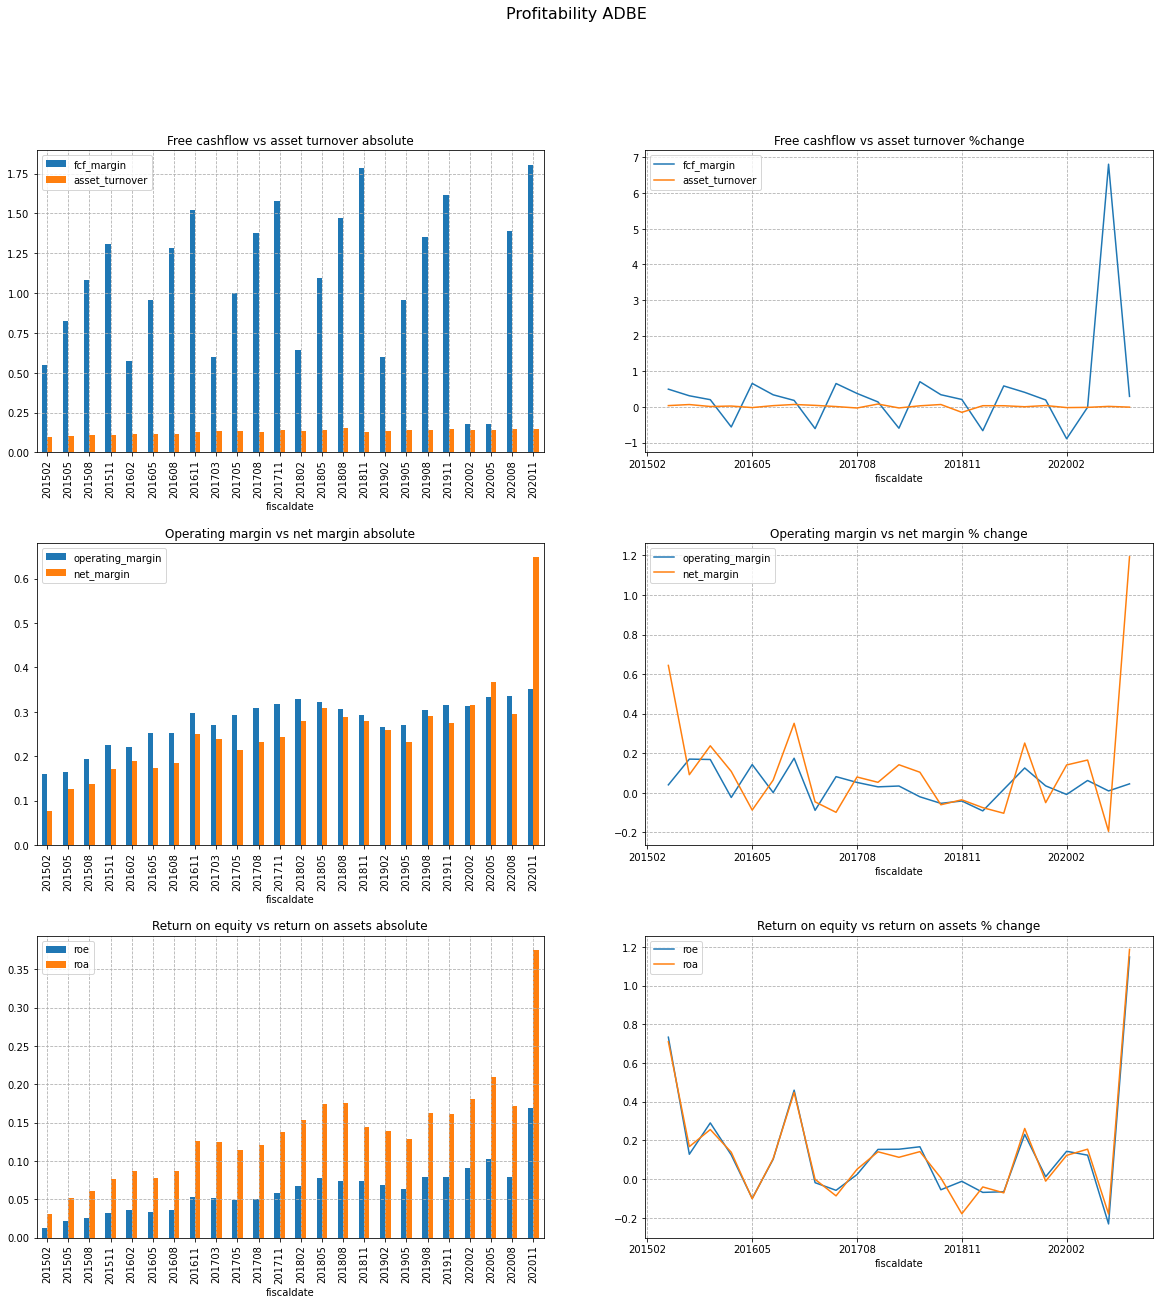

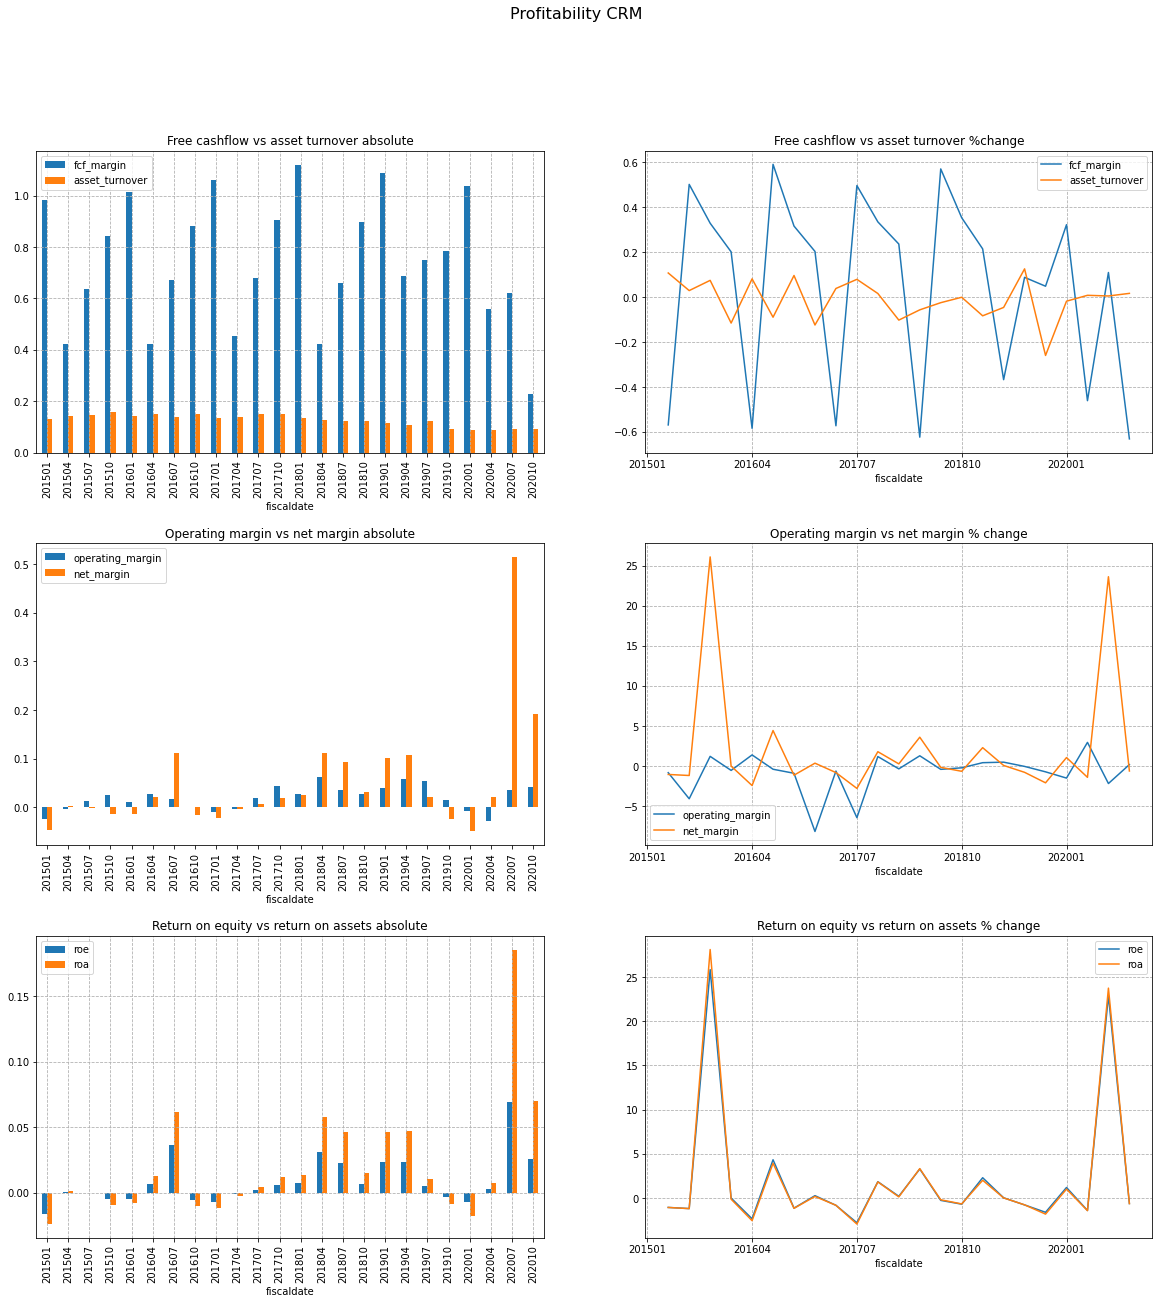

In [218]:
graphs_profitability(portfolio)

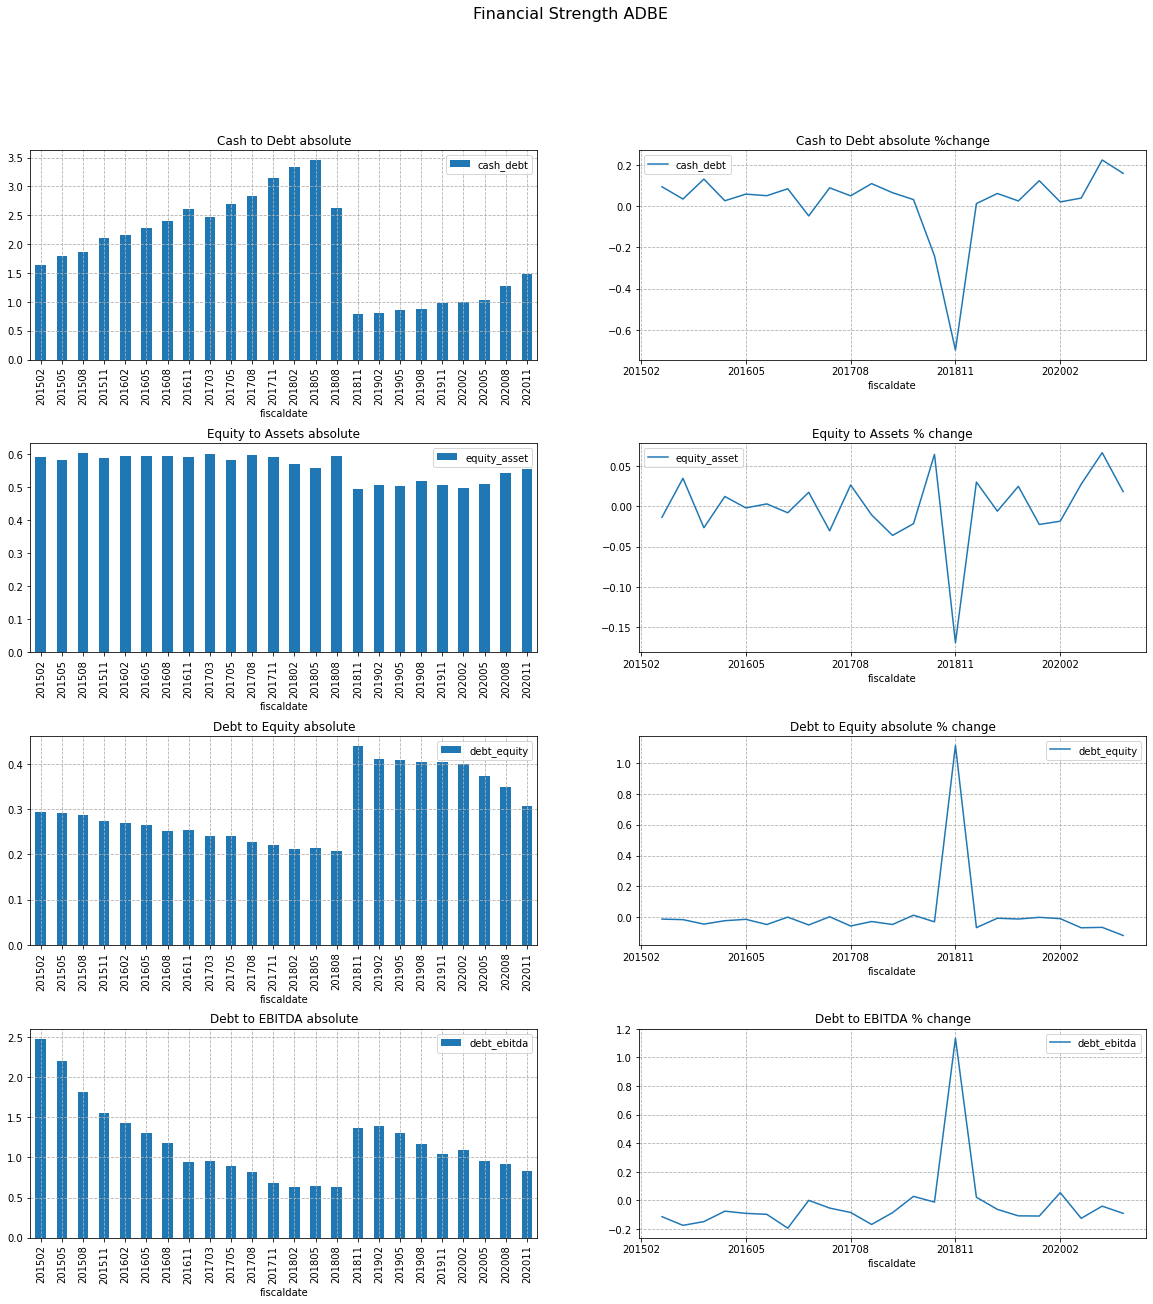

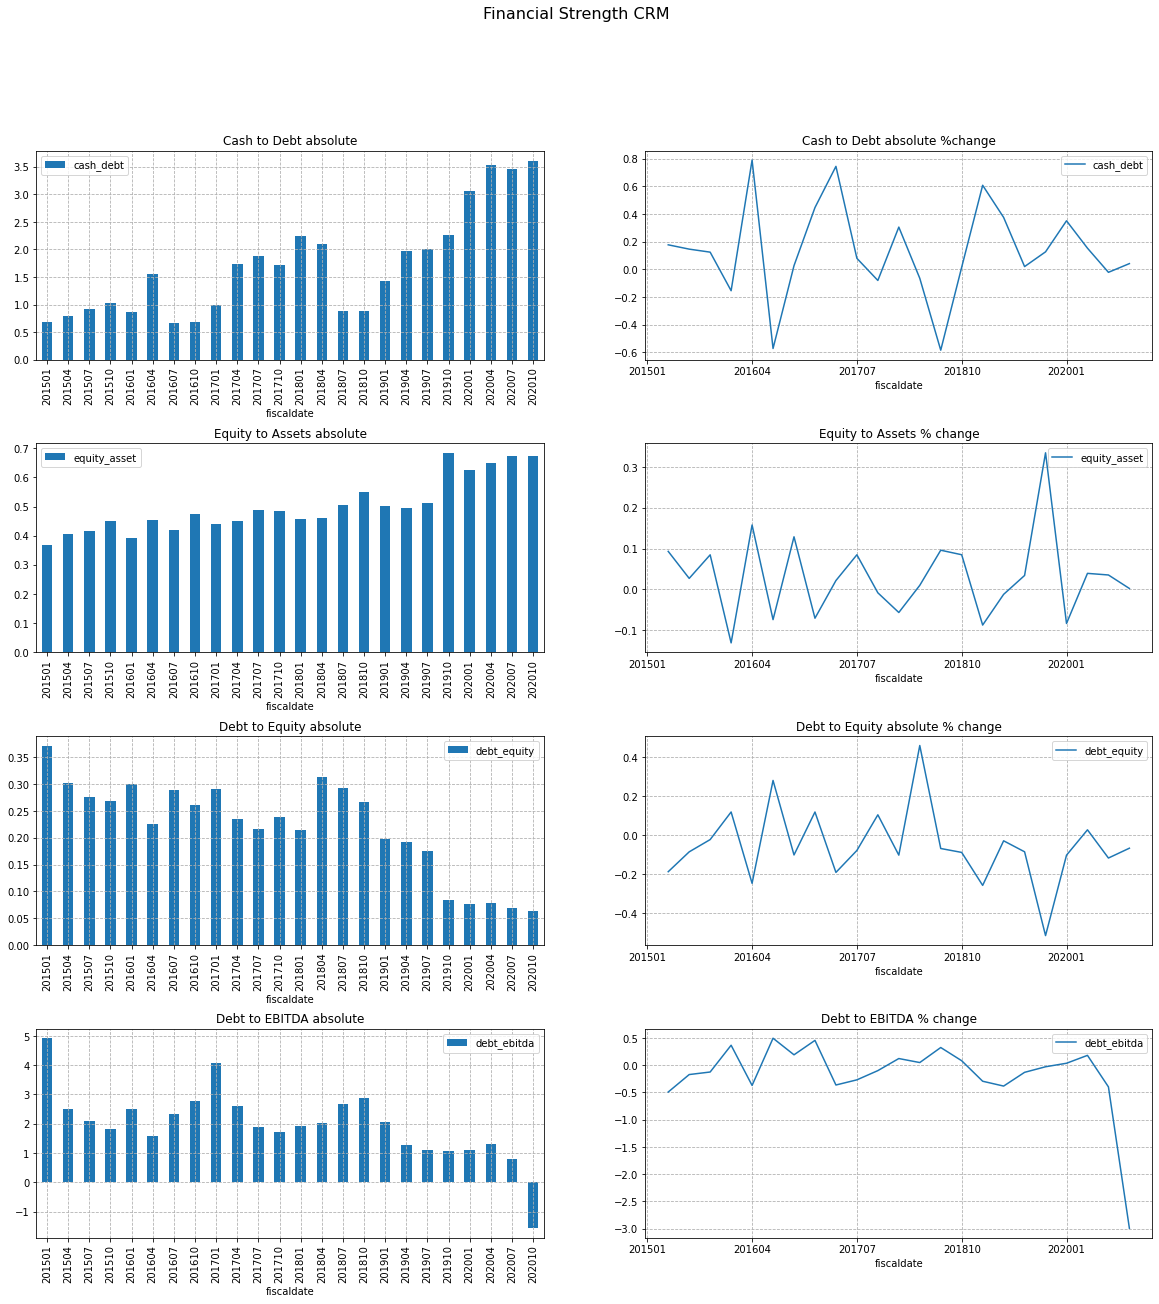

In [219]:
graphs_security(portfolio)

In [85]:
df_port = pd.DataFrame(index=symbol)

In [99]:
for k in portfolio.keys():
    op = pd.Series(portfolio[k]['operating_margin'][0])
    #df_port['operating_margin'] = portfolio[k]['operating_margin'][0]

In [90]:
df_port

,operating_margin
ADBE,0.150085
CRM,0.150085
MSFT,0.150085
V,0.150085
BABA,0.150085
ABBV,0.150085
AY,0.150085
HASI,0.150085


In [78]:
portfolio['ADBE']['operating_margin'][0]

0.3588926790223923

In [79]:
portfolio['CRM']['operating_margin'][0]

0.040411185626592454